## Import

In [62]:
# reference : https://www.kaggle.com/code/debarshichanda/pytorch-arcface-gem-pooling-starter
import random
import math
import pandas as pd
import numpy as np
import os
import gc
import re
import glob
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

import timm
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

from collections import Counter
import warnings
warnings.filterwarnings(action='ignore') 

In [5]:
import faiss

ModuleNotFoundError: No module named 'faiss'

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [75]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':400,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED': 41,
    'DIR' : 'experiment',
    'EXP_NAME' : 'contrastive_learning-ArcFace+GeM Pooling'
}

In [10]:
## ArcFace + GeM Pooling
ctr_settings = {'emb_dim' : 256,
                "s": 30.0, 
                "m": 0.50,
                "ls_eps": 0.0,
                "easy_margin": False}

## Fixed RandomSeed

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [12]:
all_img_list = glob.glob('train/*/*')
# all_img_list = [f.replace(os.sep, '/') for f in all_img_list]

In [13]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split(os.sep)[-2])

In [14]:
df['label']

0       가구수정
1       가구수정
2       가구수정
3       가구수정
4       가구수정
        ... 
3452      훼손
3453      훼손
3454      훼손
3455      훼손
3456      훼손
Name: label, Length: 3457, dtype: object

In [15]:
train_data, val_data, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])

## Label-Encoding

In [16]:
le = preprocessing.LabelEncoder()

train_data['label'] = le.fit_transform(train_data['label'])

train_data['label_multi_hot'] = np.eye(len(le.classes_), dtype = np.int32)[train_data['label'].tolist()].tolist()

val_data['label'] = le.transform(val_data['label'])
val_data['label_multi_hot'] = np.eye(len(le.classes_), dtype = np.int32)[val_data['label'].tolist()].tolist()

In [17]:
from collections import Counter

cnt_dict = Counter(train_data['label'].tolist())
total_cnt = len(train_data['label'])
class_loss_weights = [1 - (cnt_dict[c] / total_cnt) * 1.5 for c in range(len(le.classes_))]

In [18]:
le.classes_

array(['가구수정', '걸레받이수정', '곰팡이', '꼬임', '녹오염', '들뜸', '면불량', '몰딩수정', '반점',
       '석고수정', '오염', '오타공', '울음', '이음부불량', '창틀,문틀수정', '터짐', '틈새과다', '피스',
       '훼손'], dtype=object)

## CustomDataset

In [19]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        try :
            image = np.array(Image.open(img_path))
        except :
            print(img_path)
            raise
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [20]:
train_transform = A.Compose([
                            
                            A.ColorJitter(),
                            A.HorizontalFlip(),
                            A.Rotate(limit = 90),
                            A.RandomCropFromBorders(crop_left=0.1, crop_right=0.1, crop_top=0.1, crop_bottom=0.1, always_apply=False, p=1.0),
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

## weighted random sampler

In [21]:
cnt_dict = Counter(train_data['label'].tolist())
total_cnt = len(train_data['label'])
class_weights = [1/ cnt_dict[c] for c in range(len(le.classes_))]
class_weights

[0.125,
 0.004651162790697674,
 0.00980392156862745,
 0.006802721088435374,
 0.1,
 0.02631578947368421,
 0.014492753623188406,
 0.01098901098901099,
 0.5,
 0.025,
 0.002403846153846154,
 0.010101010101010102,
 0.06666666666666667,
 0.08333333333333333,
 0.05263157894736842,
 0.008849557522123894,
 0.25,
 0.027777777777777776,
 0.001017293997965412]

In [22]:
train_dataset = CustomDataset(train_data['img_path'].values, np.int64(train_data['label'].values))
sample_weights = [0] * len(train_dataset)
for idx, (data, label) in enumerate(train_dataset) :
    sample_weights[idx] = class_weights[label]
train_sampler = WeightedRandomSampler(sample_weights, num_samples = len(train_dataset), replacement = True)

In [23]:
# train_multi_hot_for_sampler = 

# train_sampler = MultilabelBalancedRandomSampler()

train_dataset = CustomDataset(train_data['img_path'].values, np.int64(train_data['label'].values), train_transform, )
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0, sampler = train_sampler)

val_dataset = CustomDataset(val_data['img_path'].values, np.int64(val_data['label'].values), test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


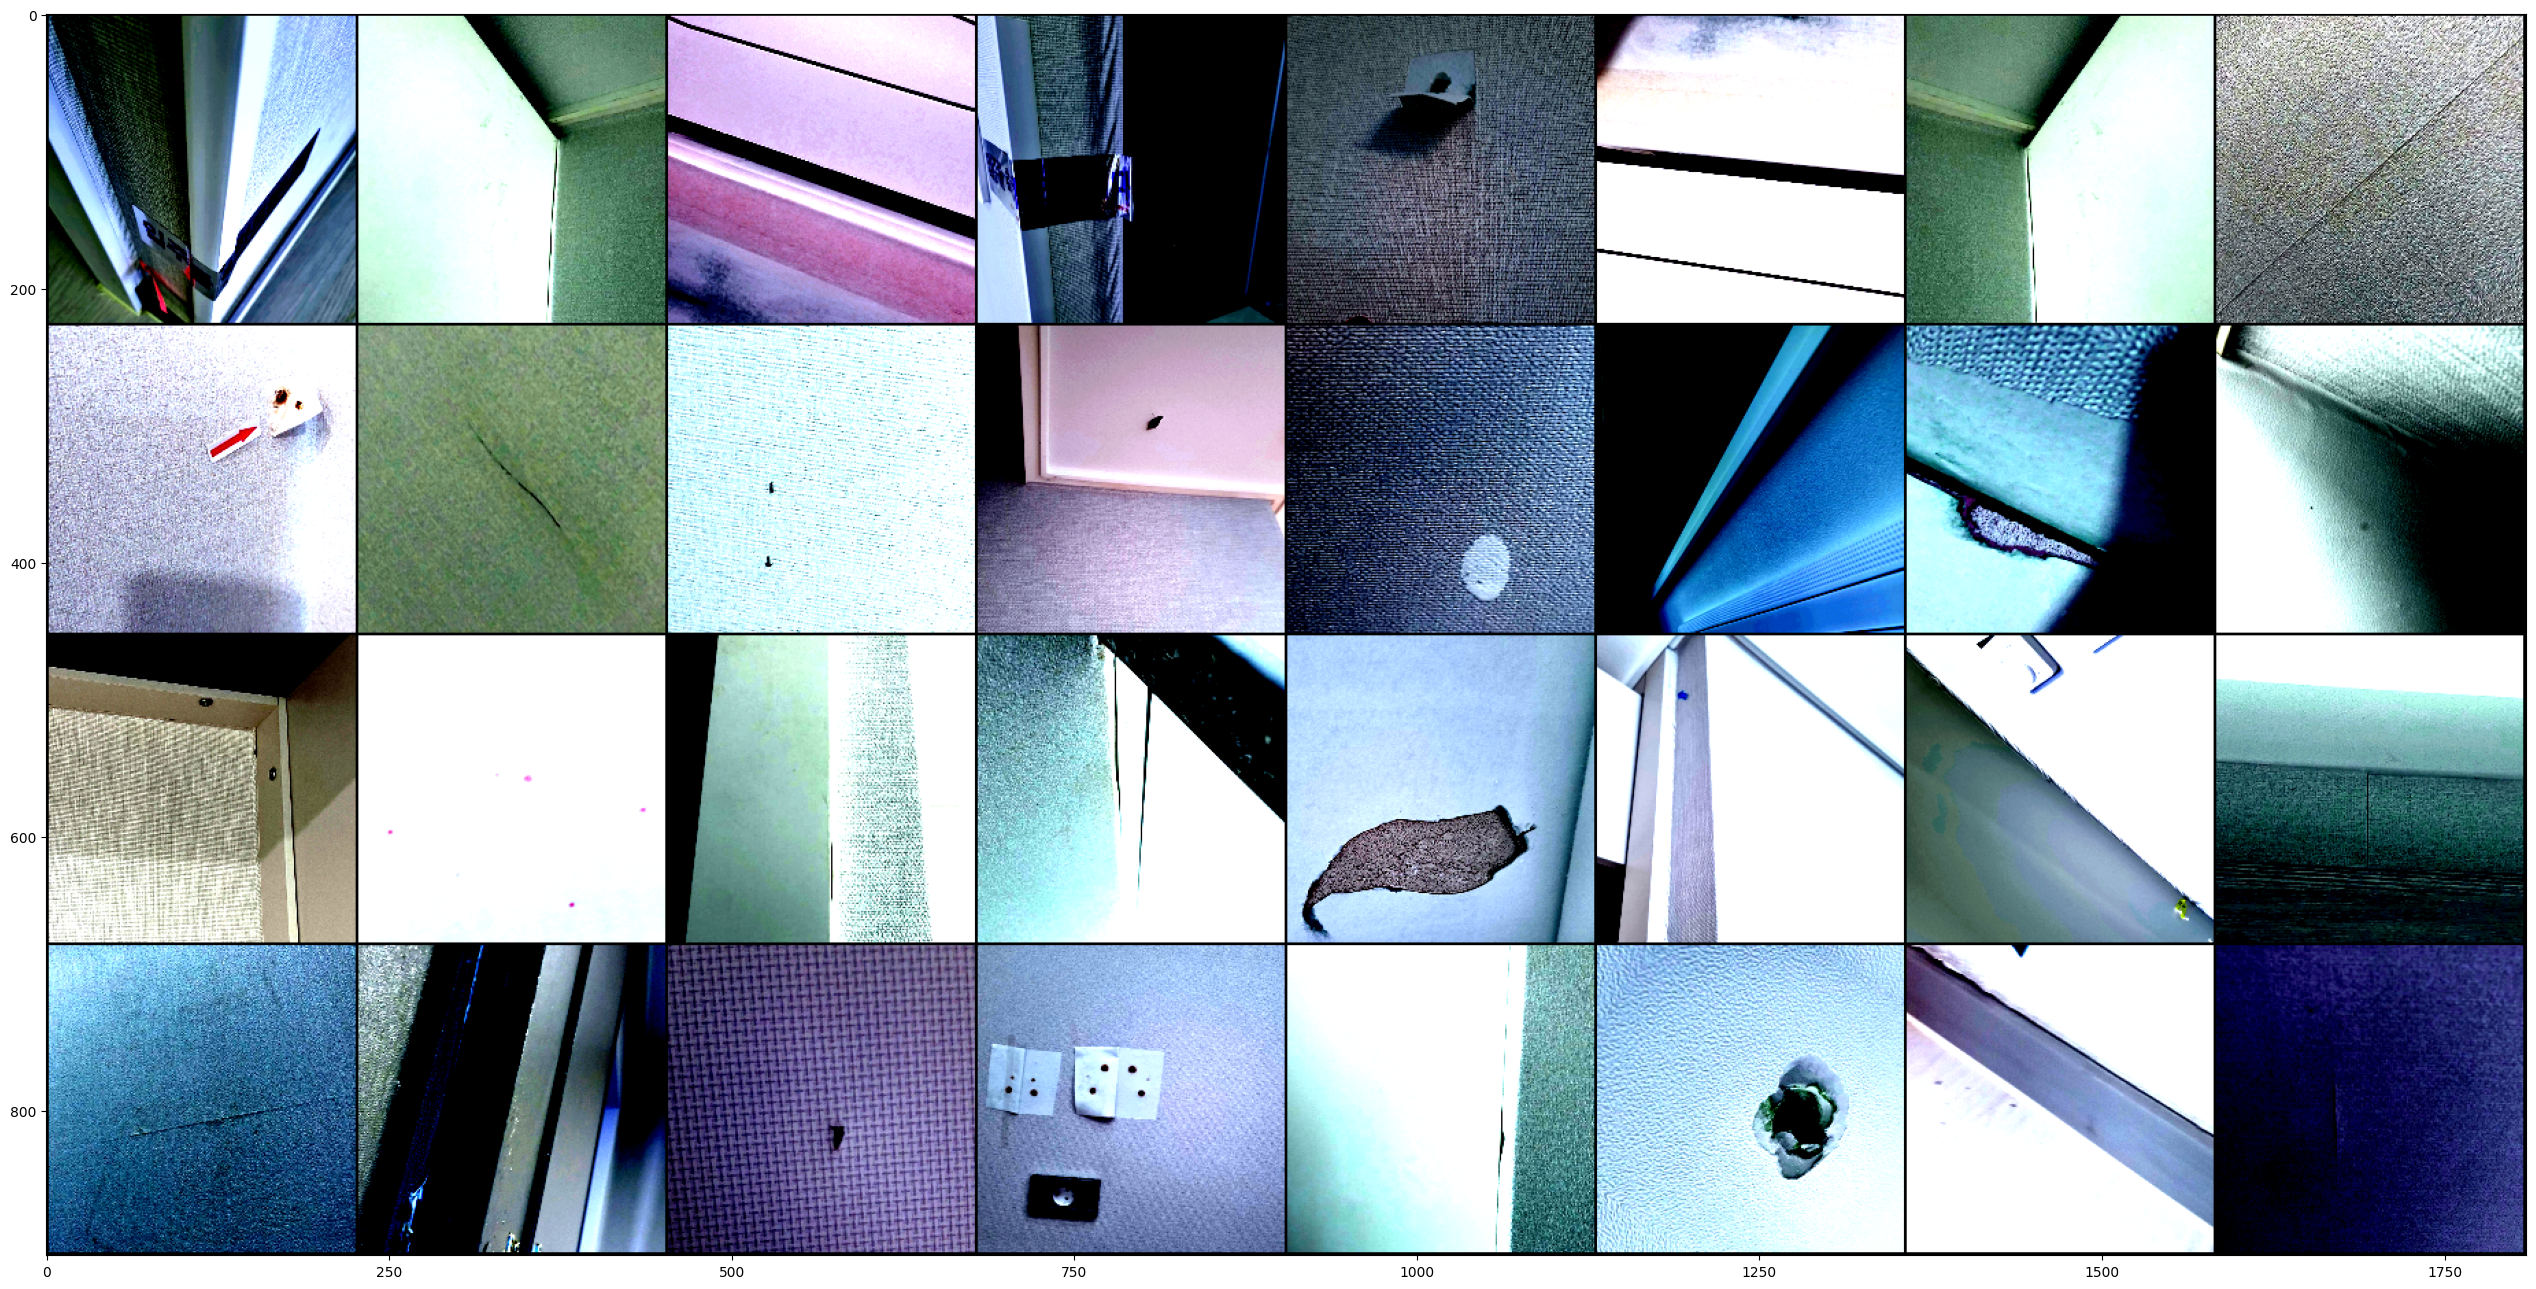

In [24]:
import torchvision

imgs, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(imgs).permute(1,2,0).detach().cpu().numpy()

plt.figure(figsize = (32, 64))
plt.imshow(grid)
plt.show()



## Model Define

In [25]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [26]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, 
                 m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label, device):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        # one_hot = torch.zeros_like(cosine)
        # one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        one_hot = torch.eye(cosine.size(1))[label.detach().cpu().numpy()].to(device)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [ ]:
num_classes = len(le.classes_)
fc = ArcMarginProduct(ctr_settings['emb_dim'],
                num_classes,
                s = ctr_settings['s'],
                m = ctr_settings['m'],
                easy_margin = ctr_settings['ls_eps'],
                ls_eps = ctr_settings['ls_eps'])

batch_size = 32

input = torch.randn((batch_size, ctr_settings['emb_dim']))

label = torch.tensor([0] * 19)


torch.eye(19)[label]


In [ ]:
backbone = models.efficientnet_b0(pretrained=True)

backbone.classifier[1].in_features

In [27]:
class LightningModel(pl.LightningModule) :
    def __init__(self, num_classes = len(le.classes_)) :
        super().__init__()
        self.backbone = timm.create_model('tf_efficientnet_b0_ns', pretrained=True)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        self.pooling = GeM()
        self.embedding = nn.Linear(in_features, ctr_settings['emb_dim'])
        self.fc = ArcMarginProduct(ctr_settings['emb_dim'],
                                   num_classes,
                                   s = ctr_settings['s'],
                                   m = ctr_settings['m'],
                                   easy_margin = ctr_settings['ls_eps'],
                                   ls_eps = ctr_settings['ls_eps'])
        self.criterion = nn.CrossEntropyLoss()

        self.val_preds = []
        self.val_labels = []
        self.val_loss_list = []

        # self.log_dict(CFG)

    def forward(self, x, labels):
        features = self.backbone(x)
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        output = self.fc(embedding, labels, device = self.device)
        return output

    def extract(self, images) :
        features = self.backbone(images)
        # print(images.shape)
        # print(features.shape)
        # print(features.clamp(min=1e-7).pow(1).shape, (features.size(-2), features.size(-1)))
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        return embedding

    def training_step(self, batch, batch_idx) :
        imgs, labels = batch

        output = self.forward(imgs, labels)
        # print(output.shape)
        loss = self.criterion(output, labels)
        self.log('train_loss', loss)

        return loss

    def configure_optimizers(self) :
        optimizer = optim.Adam(self.parameters(), lr=CFG['LEARNING_RATE'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
        monitor = LearningRateMonitor()
        
        return  {"optimizer": optimizer, "lr_scheduler": {'scheduler' : scheduler, 'monitor' : 'val_score'}, 'monitor' : monitor}

    def validation_step(self, batch, batch_idx) :
        imgs, labels = batch
        pred = self.extract(imgs)
        val_loss = self.criterion(pred, labels)
        self.log('val_loss', val_loss)

        self.val_preds += pred.argmax(1).detach().cpu().numpy().tolist()
        self.val_labels += labels.detach().cpu().numpy().tolist()
        self.val_loss_list.append(val_loss.item())


    def on_validation_epoch_end(self) :
        val_loss = np.mean(self.val_loss_list)
        val_f1score = f1_score(self.val_labels, self.val_preds, average = 'weighted')
        
        self.log('mean_val_loss', val_loss)
        self.log('val_score', val_f1score)

        self.val_loss_list.clear()
        self.val_labels.clear()
        self.val_preds.clear()

        return val_loss, val_f1score

    def predict_step(self, batch, batch_idx) :
        x = batch
        pred = self.extract(x)
        return pred

    


## Train

## Run!!

In [76]:
# callbacks
ckpt_callback = ModelCheckpoint(
    monitor = 'val_loss',
    mode = 'min',
    dirpath = os.path.join(CFG['DIR'], CFG['EXP_NAME']),
    filename = '{epoch}-{val_loss:.2f}-{val_score:.2f}'
)

early_stop_callback = EarlyStopping(
    monitor="train_loss",
    patience=20,
    verbose=False,
    mode="min"
)


tb_logger = pl_loggers.TensorBoardLogger(save_dir = CFG['DIR'], name = CFG['EXP_NAME'])

model = LightningModel()
trainer = pl.Trainer(
    max_epochs = CFG['EPOCHS'],
    accelerator = 'auto',
    precision = 16,
    logger = tb_logger,
    callbacks = [ ckpt_callback] # early_stop_callback,
)

trainer.fit(model, train_dataloaders = train_loader, val_dataloaders = val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | backbone  | EfficientNet     | 4.0 M 
1 | pooling   | GeM              | 1     
2 | embedding | Linear           | 327 K 
3 | fc        | ArcMarginProduct | 4.9 K 
4 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.361    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 1.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 7.5000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 3.7500e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 1.8750e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 9.3750e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Extract Feature

In [64]:
model = LightningModel()

infer_model = model.load_from_checkpoint('experiment/contrastive_learning-ArcFace+GeM Pooling/epoch=31-val_loss=5.98-val_score=0.00.ckpt')
infer_model

LightningModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), st

In [65]:
embeds = []
label_arr = []

for data in val_loader :
    imgs, labels = data

    output = model.extract(imgs)

    embeds.append(output.detach().cpu().numpy())
    label_arr.append(labels)

embeds = np.vstack(embeds)
label_arr = np.concatenate(label_arr)



In [66]:
normalized_embeds = normalize(embeds, norm = 'l2')
decode_label_arr = le.inverse_transform(label_arr)

In [67]:
np.save('label.npy', label_arr)
np.save('embed.npy', normalized_embeds)

In [ ]:
import faiss

index = faiss.IndexFlatIP(ctr_settings['emb_dim'])
index.add(normalized_embeds)

## Inference

In [68]:
test = pd.read_csv('./test.csv')

### PCA visualization

In [69]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(normalized_embeds)

df_pca = pca.transform(normalized_embeds)



### t-SNE

In [72]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
df_tsne = tsne.fit_transform(normalized_embeds)

df_tsne = pd.DataFrame(df_tsne)
df_tsne['target'] = val_data['label'].tolist()

In [70]:
df_pca = pd.DataFrame(df_pca)
df_pca['target'] = val_data['label'].tolist()

df_pca

0         1  target
0    -0.153064  0.166029       1
1     0.256755  0.007253      18
2    -0.076985  0.150816       1
3     0.122048  0.176980      10
4     0.033043 -0.114596      18
...        ...       ...     ...
1033 -0.188296 -0.230127      15
1034  0.139347 -0.106458      10
1035 -0.249010 -0.231652      18
1036 -0.216536  0.062111       3
1037  0.030977  0.010163      18

[1038 rows x 3 columns]

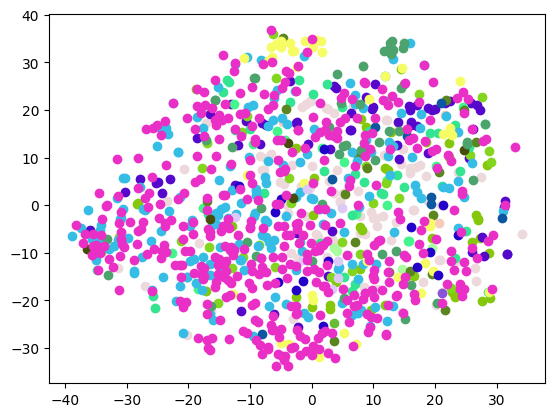

In [73]:
markers = range(len(le.classes_))

hexadecimal_alphabets = '0123456789ABCDEF'

color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
range(6)]) for i in range(len(markers))]

for i, marker in enumerate(markers):
  x_val = df_tsne[df_tsne["target"] ==i][0] 
  y_val = df_tsne[df_tsne["target"]==i][1] 
  plt.scatter(x_val, y_val, label=le.classes_, c = color[i]) 
# plt.legend() 
# plt.xlabel("x") 
# plt.ylabel("y") 
plt.show() 

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
## inference

trainer = pl.Trainer()
predictions = trainer.predict(infer_model, test_loader)
final_result = []
for pred_batch in predictions :
    final_result += pred_batch.argmax(1).detach().cpu().numpy().tolist()

final_result = le.inverse_transform(final_result)


## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit['label'] = final_result

In [ ]:
submit.to_csv('./baseline+class_weight_submit_v3.csv', index=False)